## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.5, 0.2]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0805 21:11:55.224212  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 21:11:55.226213  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 21:11:55.230213  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 21:11:55.307213  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 5


W0805 21:11:55.518213  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 21:11:55.532212  1744 deprecation_wrapper.py:119] From C:\Users\Hui\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 21:11:55.637213  1744 deprecation.py:323] From C:\Users\Hui\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 82us/step - loss: 1.2088 - acc: 0.5804 - val_loss: 1.4795 - val_acc: 0.4786
Epoch 15/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1860 - acc: 0.5910 - val_loss: 1.4752 - val_acc: 0.4812
Epoch 16/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1611 - acc: 0.5990 - val_loss: 1.4669 - val_acc: 0.4840
Epoch 17/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1380 - acc: 0.6086 - val_loss: 1.4626 - val_acc: 0.4845
Epoch 18/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1161 - acc: 0.6168 - val_loss: 1.4586 - val_acc: 0.4903
Epoch 19/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0919 - acc: 0.6259 - val_loss: 1.4571 - val_acc: 0.4915
Epoch 20/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.0696 - acc: 0.6343 - val_loss: 1.4515 - val_acc: 0.4931
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 95us/step - loss: 2.2212 - acc: 0.2640 - val_loss: 2.0428 - val_acc: 0.3371
Epoch 2/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.7372 - acc: 0.3931 - val_loss: 1.8228 - val_acc: 0.3690
Epoch 3/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.6174 - acc: 0.4334 - val_loss: 1.6912 - val_acc: 0.4064
Epoch 4/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5442 - acc: 0.4607 - val_loss: 1.6226 - val_acc: 0.4242
Epoch 5/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4907 - acc: 0.4774 - val_loss: 1.5894 - val_acc: 0.4366
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4439 - acc: 0.4955 - val_loss: 1.5682 - val_acc: 0.4436
Epoch 7/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.4037 - acc: 0.5103 - val_loss: 1.5551 - val_acc: 0.4516
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 4s 81us/step - loss: 1.1888 - acc: 0.5914 - val_loss: 1.4913 - val_acc: 0.4786
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.1749 - acc: 0.5966 - val_loss: 1.4853 - val_acc: 0.4777
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3878 - acc: 0.5174 - val_loss: 1.5558 - val_acc: 0.4472
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3677 - acc: 0.5253 - val_loss: 1.5479 - val_acc: 0.4507
Epoch 14/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3490 - acc: 0.5322 - val_loss: 1.5357 - val_acc: 0.4577
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3304 - acc: 0.5386 - val_loss: 1.5286 - val_acc: 0.4608
Epoch 16/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3112 - acc: 0.5453 - val_loss: 1.5229 - val_acc: 0.4666
Epoch 17/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2953 - acc: 0.5518 - val_loss: 1.5141 - val_acc: 0.4663
Epoch 18/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.2776 - acc: 0.5582 - val_loss: 1.5079 - val_acc: 0.4664
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.3523 - acc: 0.2376 - val_loss: 2.1997 - val_acc: 0.2834
Epoch 2/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8615 - acc: 0.3544 - val_loss: 1.8953 - val_acc: 0.3574
Epoch 3/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7243 - acc: 0.3944 - val_loss: 1.7776 - val_acc: 0.3839
Epoch 4/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.6494 - acc: 0.4215 - val_loss: 1.7114 - val_acc: 0.3993
Epoch 5/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5942 - acc: 0.4393 - val_loss: 1.6620 - val_acc: 0.4145
Epoch 6/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.5508 - acc: 0.4548 - val_loss: 1.6342 - val_acc: 0.4258
Epoch 7/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5153 - acc: 0.4691 - val_loss: 1.6177 - val_ac

50000/50000 [==============================] - 5s 92us/step - loss: 0.4418 - acc: 0.8587 - val_loss: 1.7936 - val_acc: 0.4859
Epoch 24/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.3986 - acc: 0.8774 - val_loss: 1.8545 - val_acc: 0.4913
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.3733 - acc: 0.8844 - val_loss: 1.8373 - val_acc: 0.4873
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_lay

50000/50000 [==============================] - 5s 93us/step - loss: 1.0818 - acc: 0.6189 - val_loss: 1.5589 - val_acc: 0.4511
Epoch 11/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0399 - acc: 0.6338 - val_loss: 1.5363 - val_acc: 0.4633
Epoch 12/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.0076 - acc: 0.6465 - val_loss: 1.6206 - val_acc: 0.4486
Epoch 13/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.9700 - acc: 0.6593 - val_loss: 1.5717 - val_acc: 0.4604
Epoch 14/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.9345 - acc: 0.6727 - val_loss: 1.5570 - val_acc: 0.4705
Epoch 15/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.8976 - acc: 0.6865 - val_loss: 1.5105 - val_acc: 0.4877
Epoch 16/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.8625 - acc: 0.7011 - val_loss: 1.6552 - val_acc: 0.4624
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.7983 - acc: 0.3781 - val_loss: 1.8258 - val_acc: 0.3788
Epoch 2/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.5026 - acc: 0.4725 - val_loss: 1.7545 - val_acc: 0.3957
Epoch 3/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.4090 - acc: 0.5058 - val_loss: 1.5654 - val_acc: 0.4420
Epoch 4/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.3390 - acc: 0.5306 - val_loss: 1.5833 - val_acc: 0.4351
Epoch 5/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.2802 - acc: 0.5530 - val_loss: 1.4993 - val_acc: 0.4660
Epoch 6/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2326 - acc: 0.5700 - val_loss: 1.5602 - val_acc: 0.4514
Epoch 7/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.1859 - acc: 0.5879 - val_loss: 1.4780 - val_ac

50000/50000 [==============================] - 5s 93us/step - loss: 0.6900 - acc: 0.7847 - val_loss: 1.5465 - val_acc: 0.4902
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.6695 - acc: 0.7922 - val_loss: 1.5019 - val_acc: 0.4985
Numbers of exp: 15, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 5s 94us/step - loss: 1.3152 - acc: 0.5472 - val_loss: 1.5250 - val_acc: 0.4667
Epoch 12/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2978 - acc: 0.5533 - val_loss: 1.5303 - val_acc: 0.4674
Epoch 13/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2788 - acc: 0.5603 - val_loss: 1.5228 - val_acc: 0.4702
Epoch 14/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2612 - acc: 0.5661 - val_loss: 1.5125 - val_acc: 0.4703
Epoch 15/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2455 - acc: 0.5743 - val_loss: 1.5024 - val_acc: 0.4776
Epoch 16/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2309 - acc: 0.5796 - val_loss: 1.5036 - val_acc: 0.4783
Epoch 17/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.2155 - acc: 0.5869 - val_loss: 1.4931 - val_acc: 0.4809
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8110 - acc: 0.3755 - val_loss: 3.4762 - val_acc: 0.2187
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5442 - acc: 0.4538 - val_loss: 3.8004 - val_acc: 0.1719
Epoch 3/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.4364 - acc: 0.4932 - val_loss: 2.4775 - val_acc: 0.2407
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3670 - acc: 0.5170 - val_loss: 2.1721 - val_acc: 0.3038
Epoch 5/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3065 - acc: 0.5382 - val_loss: 2.4025 - val_acc: 0.3098
Epoch 6/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2465 - acc: 0.5610 - val_loss: 2.6413 - val_acc: 0.2706
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2032 - acc: 0.5768 - val_loss: 2.2178 - val_ac

50000/50000 [==============================] - 4s 88us/step - loss: 0.6696 - acc: 0.7706 - val_loss: 2.3812 - val_acc: 0.3541
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.6440 - acc: 0.7809 - val_loss: 2.3567 - val_acc: 0.3831
Epoch 25/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.6222 - acc: 0.7877 - val_loss: 1.9991 - val_acc: 0.4066

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Numbers of exp: 20, reduce_factor: 0.80, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048  

50000/50000 [==============================] - 4s 88us/step - loss: 1.0529 - acc: 0.6334 - val_loss: 1.7790 - val_acc: 0.3948
Epoch 11/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.0120 - acc: 0.6481 - val_loss: 2.0186 - val_acc: 0.3775
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.9789 - acc: 0.6608 - val_loss: 1.7954 - val_acc: 0.4111
Epoch 13/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.9540 - acc: 0.6697 - val_loss: 1.7038 - val_acc: 0.4295
Epoch 14/25
50000/50000 [==============================] - 4s 90us/step - loss: 0.9217 - acc: 0.6825 - val_loss: 1.6584 - val_acc: 0.4350
Epoch 15/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.8872 - acc: 0.6932 - val_loss: 1.8153 - val_acc: 0.4078
Epoch 16/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.8578 - acc: 0.7055 - val_loss: 1.8155 - val_acc: 0.4155
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.8144 - acc: 0.3716 - val_loss: 2.3545 - val_acc: 0.3158
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5368 - acc: 0.4644 - val_loss: 1.9250 - val_acc: 0.3527
Epoch 3/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.4245 - acc: 0.5020 - val_loss: 2.2157 - val_acc: 0.3035
Epoch 4/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.3466 - acc: 0.5307 - val_loss: 1.9185 - val_acc: 0.3428
Epoch 5/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.2897 - acc: 0.5499 - val_loss: 2.4939 - val_acc: 0.2946
Epoch 6/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2376 - acc: 0.5700 - val_loss: 2.5607 - val_acc: 0.2431
Epoch 7/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1897 - acc: 0.5866 - val_loss: 2.2483 - val_ac

50000/50000 [==============================] - 4s 88us/step - loss: 0.6974 - acc: 0.7809 - val_loss: 1.3922 - val_acc: 0.5248

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0240000847261399e-05.
Epoch 24/25
50000/50000 [==============================] - 4s 88us/step - loss: 0.6668 - acc: 0.7961 - val_loss: 1.3566 - val_acc: 0.5353
Epoch 25/25
50000/50000 [==============================] - 4s 89us/step - loss: 0.6625 - acc: 0.7993 - val_loss: 1.3634 - val_acc: 0.5344
Numbers of exp: 25, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048 

50000/50000 [==============================] - 4s 89us/step - loss: 1.6381 - acc: 0.4295 - val_loss: 1.7349 - val_acc: 0.4028
Epoch 11/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.6126 - acc: 0.4379 - val_loss: 1.7153 - val_acc: 0.4108
Epoch 12/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5906 - acc: 0.4459 - val_loss: 1.6987 - val_acc: 0.4152
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5699 - acc: 0.4550 - val_loss: 1.6884 - val_acc: 0.4179
Epoch 14/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5504 - acc: 0.4600 - val_loss: 1.6801 - val_acc: 0.4203
Epoch 15/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5316 - acc: 0.4675 - val_loss: 1.6644 - val_acc: 0.4255
Epoch 16/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5147 - acc: 0.4725 - val_loss: 1.6520 - val_acc: 0.4307
Epoch 17/25
50000/50000 [=====================

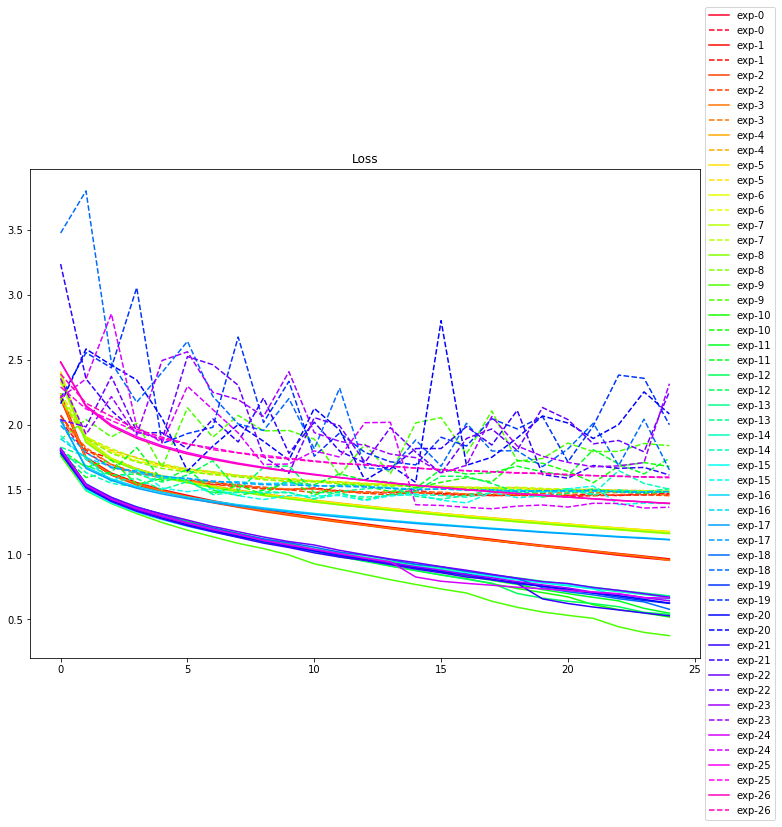

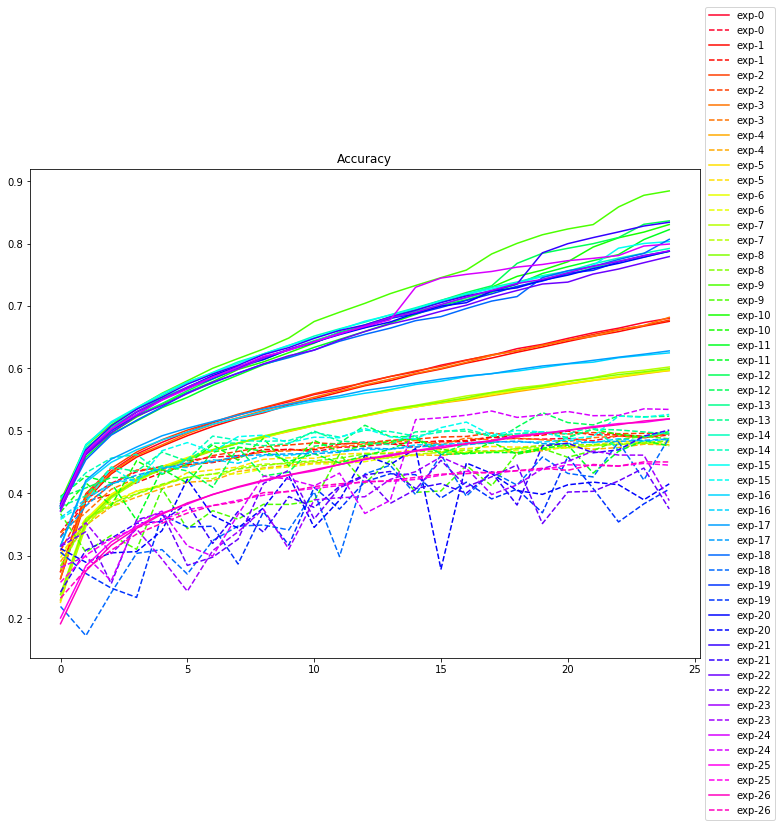

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()